# Importing Packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchsummary import summary
from torchmetrics import JaccardIndex

import time
import copy
import os

In [2]:
data_dir = '../datasets/camouflage_image_segmentation/Images'
mask_dir = '../datasets/camouflage_image_segmentation/Masks'

In [3]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ColorJitter(),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
}
mask_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
}

## PyTorch Custom Dataset

In [4]:
class ImageMaskDataset(Dataset):
    def __init__(self, data_dir, mask_dir, train = True, transform = None, mask_transform = None) -> None:
        super(ImageMaskDataset, self).__init__()
        self.imgs = []
        self.transform = transform
        if train:
            for file1 in os.scandir(data_dir+'/Train'):
                file2 = mask_dir+'/Train/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
        else:
            for file1 in os.scandir(data_dir+'/Validation'):
                file2 = mask_dir+'/Validation/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
                    # if self.imgs[-1][0].shape[0] == 1:
                    #     self.imgs[-1] = (self.imgs[-1][0].repeat(3,1,1), self.imgs[-1][1])
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [5]:
train_data = ImageMaskDataset(data_dir, mask_dir, train = True, transform=data_transforms['Train'], mask_transform=mask_transforms['Train'])
val_data = ImageMaskDataset(data_dir, mask_dir, train = False, transform=data_transforms['Validation'], mask_transform=mask_transforms['Validation'])

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle = True,
)
val_loader = DataLoader(
    val_data,
    batch_size = 64,
    shuffle = True,
)

## Image plot

In [7]:
def image_show(image, mask, pred = None):
    image = image*0.5 + 0.5
    mask = mask*0.5 + 0.5
    plt.figure(figsize=(20,10))
    if pred is not None:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('True Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(pred.detach().numpy().transpose((1,2,0)), cmap='gray')
    else:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')

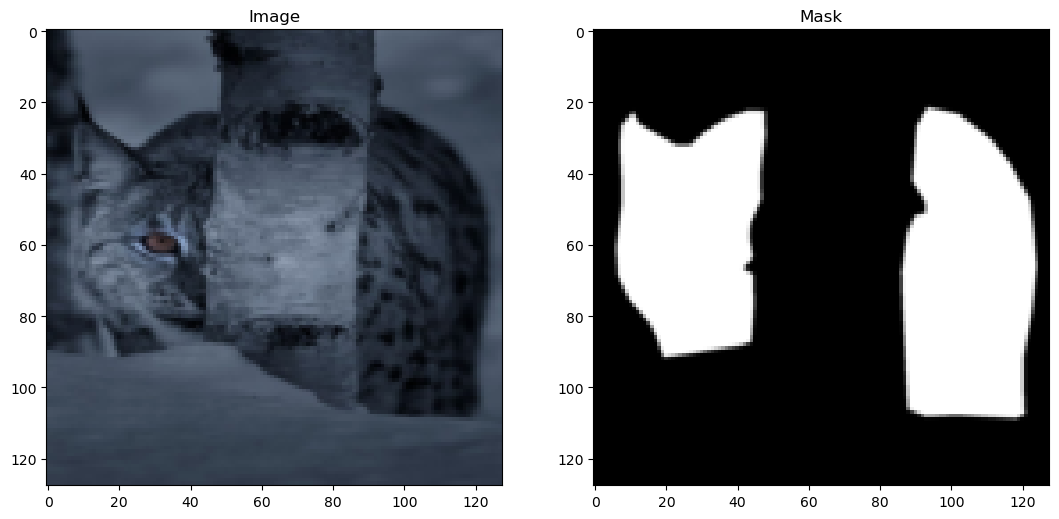

In [8]:
dataiter = iter(train_loader)
image, mask = next(dataiter)
index = 0
image_show(image[index], mask[index])

In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # mps: Metal Performance Shaders - For Apple M1 GPU
device

device(type='mps')

# U-Net

In [10]:
class UNet(nn.Module):
    def __init__(self) -> None:
        super(UNet, self).__init__()

        # ENCODER
        self.conv11 = nn.Conv2d(3, 8, 7, 1, 'same') # 128, 128, 3 --> 128, 128, 8
        self.norm11 = nn.BatchNorm2d(8)
        self.conv12 = nn.Conv2d(8, 32, 5, 1, 'same') # 128, 128, 8 --> 128, 128, 32
        self.norm12 = nn.BatchNorm2d(32)
        self.conv13 = nn.Conv2d(32, 64, 3, 1, 'same') # 128, 128, 32 --> 128, 128, 64
        self.norm13 = nn.BatchNorm2d(64)

        self.maxpool1 = nn.MaxPool2d(2,2) # 64, 64, 64

        self.conv21 = nn.Conv2d(64, 128, 7, 1, 'same') # 64, 64, 64 --> 64, 64, 128
        self.norm21 = nn.BatchNorm2d(128)
        self.conv22 = nn.Conv2d(128, 128, 5, 1, 'same') # 64, 64, 128 --> 64, 64, 128
        self.norm22 = nn.BatchNorm2d(128)
        self.conv23 = nn.Conv2d(128, 128, 3, 1, 'same') # 64, 64, 128 --> 64, 64, 128
        self.norm23 = nn.BatchNorm2d(128)

        self.maxpool2 = nn.MaxPool2d(2,2) # 32, 32, 128

        self.conv31 = nn.Conv2d(128, 256, 5, 1, 'same') # 32, 32, 128 --> 32, 32, 256
        self.norm31 = nn.BatchNorm2d(256)
        self.conv32 = nn.Conv2d(256, 256, 5, 1, 'same') # 32, 32, 256 --> 32, 32, 256
        self.norm32 = nn.BatchNorm2d(256)
        self.conv33 = nn.Conv2d(256, 256, 3, 1, 'same') # 32, 32, 256 --> 32, 32, 256
        self.norm33 = nn.BatchNorm2d(256)

        self.maxpool3 = nn.MaxPool2d(2,2) # 16, 16, 128

        self.conv41 = nn.Conv2d(256, 512, 3, 1, 1) # 16, 16, 256 --> 16, 16, 512
        self.norm41 = nn.BatchNorm2d(512)
        self.conv42 = nn.Conv2d(512, 512, 3, 1, 1) # 16, 16, 256 --> 16, 16, 512
        self.norm42 = nn.BatchNorm2d(512)
        self.conv43 = nn.Conv2d(512, 512, 3, 1, 1) # 16, 16, 256 --> 16, 16, 512
        self.norm43 = nn.BatchNorm2d(512)

        # DECODER
        self.convT1 = nn.ConvTranspose2d(512, 256, 2, 2)

        self.conv51 = nn.Conv2d(512, 512, 3, 1, 'same')
        self.norm51 = nn.BatchNorm2d(512)
        self.conv52 = nn.Conv2d(512, 512, 3, 1, 'same')
        self.norm52 = nn.BatchNorm2d(512)
        self.conv53 = nn.Conv2d(512, 512, 5, 1, 'same')
        self.norm53 = nn.BatchNorm2d(512)

        self.convT2 = nn.ConvTranspose2d(512, 128, 2, 2)

        self.conv61 = nn.Conv2d(256, 256, 3, 1, 'same')
        self.norm61 = nn.BatchNorm2d(256)
        self.conv62 = nn.Conv2d(256, 256, 5, 1, 'same')
        self.norm62 = nn.BatchNorm2d(256)
        self.conv63 = nn.Conv2d(256, 256, 5, 1, 'same')
        self.norm63 = nn.BatchNorm2d(256)

        self.convT3 = nn.ConvTranspose2d(256, 64, 2, 2)

        self.conv71 = nn.Conv2d(128, 64, 3, 1, 'same')
        self.norm71 = nn.BatchNorm2d(64)
        self.conv72 = nn.Conv2d(64, 64, 5, 1, 'same')
        self.norm72 = nn.BatchNorm2d(64)
        self.conv73 = nn.Conv2d(64, 1, 1, 1, 'same')
        self.norm73 = nn.BatchNorm2d(1)

    def forward(self, x):
        # ENCODER
        x = torch.relu(self.norm11(self.conv11(x)))
        x = torch.relu(self.norm12(self.conv12(x)))
        x_temp1 = torch.relu(self.norm13(self.conv13(x)))

        x = self.maxpool1(x_temp1)

        x = torch.relu(self.norm21(self.conv21(x)))
        x = torch.relu(self.norm22(self.conv22(x)))
        x_temp2 = torch.relu(self.norm23(self.conv23(x)))

        x = self.maxpool2(x_temp2)

        x = torch.relu(self.norm31(self.conv31(x)))
        x = torch.relu(self.norm32(self.conv32(x)))
        x_temp3 = torch.relu(self.norm33(self.conv33(x)))

        x = self.maxpool3(x_temp3)

        x = torch.relu(self.norm41(self.conv41(x)))

        # DECODER
        x = self.convT1(x)

        x = torch.cat((x,x_temp3), 1)

        x = torch.relu(self.norm51(self.conv51(x)))
        x = torch.relu(self.norm52(self.conv52(x)))
        x = torch.relu(self.norm53(self.conv53(x)))

        x = self.convT2(x)

        x = torch.cat((x,x_temp2), 1)

        x = torch.relu(self.norm61(self.conv61(x)))
        x = torch.relu(self.norm62(self.conv62(x)))
        x = torch.relu(self.norm63(self.conv63(x)))

        x = self.convT3(x)   

        x = torch.cat((x,x_temp1), 1)

        x = torch.relu(self.norm71(self.conv71(x)))
        x = torch.relu(self.norm72(self.conv72(x)))
        x = torch.sigmoid(self.norm73(self.conv73(x)))

        return x

In [11]:
unet = UNet().to(device)

In [12]:
summary(copy.deepcopy(unet).to('cpu'), (3, 128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]           1,184
       BatchNorm2d-2          [-1, 8, 128, 128]              16
            Conv2d-3         [-1, 32, 128, 128]           6,432
       BatchNorm2d-4         [-1, 32, 128, 128]              64
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         401,536
       BatchNorm2d-9          [-1, 128, 64, 64]             256
           Conv2d-10          [-1, 128, 64, 64]         409,728
      BatchNorm2d-11          [-1, 128, 64, 64]             256
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
        MaxPool2d-14          [-1, 128,

In [11]:
def binaryJaccardIndex(preds, masks):
    intersection = 0
    union = 0
    preds = preds.view(-1) # Reshaping to a single array
    masks = masks.view(-1) # Reshaping to a single array

    intersection = (preds * masks).sum()
    total = (preds + masks).sum()
    union = total - intersection 
    
    IoU = intersection/union
            
    return IoU

# Loss and Optimizer

In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(unet.parameters(), lr=5e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.7)

In [17]:
num_epochs = 30
batches = len(train_loader)
losses = []

In [ ]:
best_weights = copy.deepcopy(unet.state_dict())
max = 0
val_iou_score = 0
for epoch in range(num_epochs):
    unet.train()
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = unet(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        unet.eval()
        for images, masks in val_loader:
            image = image.to(device)
            mask = mask.to('cpu')
            pred = unet(image).cpu()
            pred = torch.round(pred)
            val_iou_score += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
        val_iou_score = val_iou_score/len(val_loader)

        if (max <= val_iou_score):
            print('SAVED MODEL WEIGHTS')
            max = val_iou_score
            best_weights = copy.deepcopy(unet.state_dict())
    
    print(f'Validation IoU Score: {val_iou_score:.4f}')
    print(f'Validation Dice Score: {(2*val_iou_score)/(1+val_iou_score):.4f}')
    print("-"*20)

In [18]:
tic = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs} (LR: {scheduler.get_last_lr()[0]:.5f})')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks.to(device))

        preds = unet.forward(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step()
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/30 (LR: 0.50000)
Step 1/16; Loss = 0.6386
Step 2/16; Loss = 0.6476
Step 3/16; Loss = 0.5847
Step 4/16; Loss = 0.5225
Step 5/16; Loss = 0.5139
Step 6/16; Loss = 0.4989
Step 7/16; Loss = 0.4982
Step 8/16; Loss = 0.4958
Step 9/16; Loss = 0.4320
Step 10/16; Loss = 0.4764
Step 11/16; Loss = 0.4563
Step 12/16; Loss = 0.4200
Step 13/16; Loss = 0.4367
Step 14/16; Loss = 0.4309
Step 15/16; Loss = 0.4264
Step 16/16; Loss = 0.4389
Epoch 2/30 (LR: 0.35000)
Step 1/16; Loss = 0.4180
Step 2/16; Loss = 0.3874
Step 3/16; Loss = 0.4084
Step 4/16; Loss = 0.3970
Step 5/16; Loss = 0.4251
Step 6/16; Loss = 0.3723
Step 7/16; Loss = 0.4246
Step 8/16; Loss = 0.3996
Step 9/16; Loss = 0.3911
Step 10/16; Loss = 0.3975
Step 11/16; Loss = 0.4333
Step 12/16; Loss = 0.4322
Step 13/16; Loss = 0.3978
Step 14/16; Loss = 0.3736
Step 15/16; Loss = 0.3830
Step 16/16; Loss = 0.4119
Epoch 3/30 (LR: 0.24500)
Step 1/16; Loss = 0.4295
Step 2/16; Loss = 0.3835
Step 3/16; Loss = 0.3760
Step 4/16; Loss = 0.3991
Step 5/16; 

Text(0.5, 1.0, 'Loss')

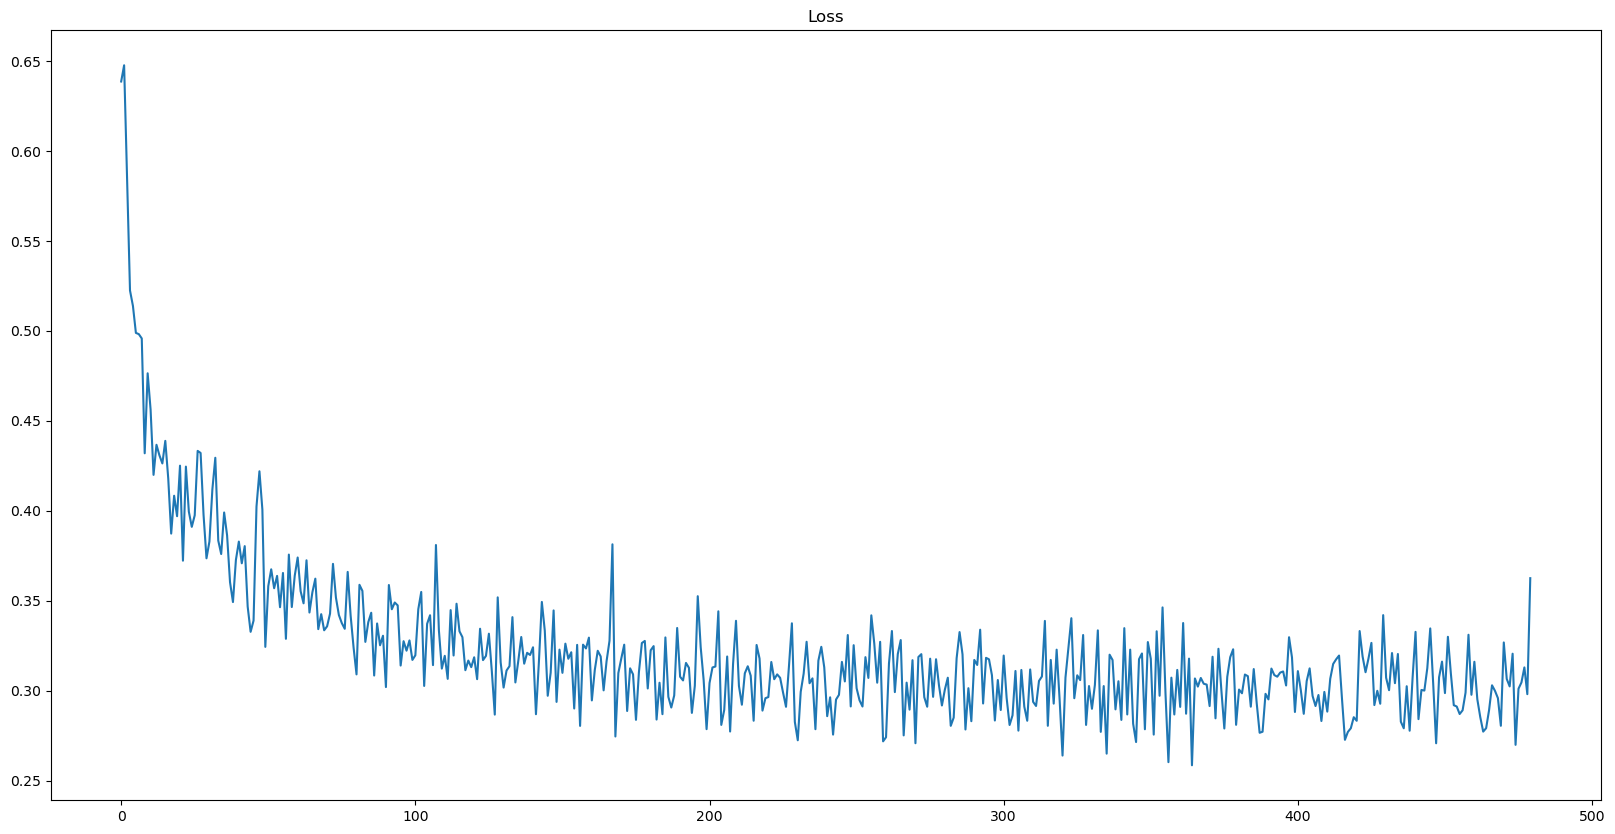

In [19]:
plt.figure(figsize=(20,10))
plt.plot(losses)
plt.title('Loss')

In [32]:
# torch.save(unet, '../models/U-Net_Image_Segmentation_IE643_2.pt')

In [12]:
unet = torch.load('../models/U-Net_Image_Segmentation_IE643_2.pt')
unet.eval()

UNet(
  (conv11): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (norm11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (norm12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv13): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (norm21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (norm22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv23): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

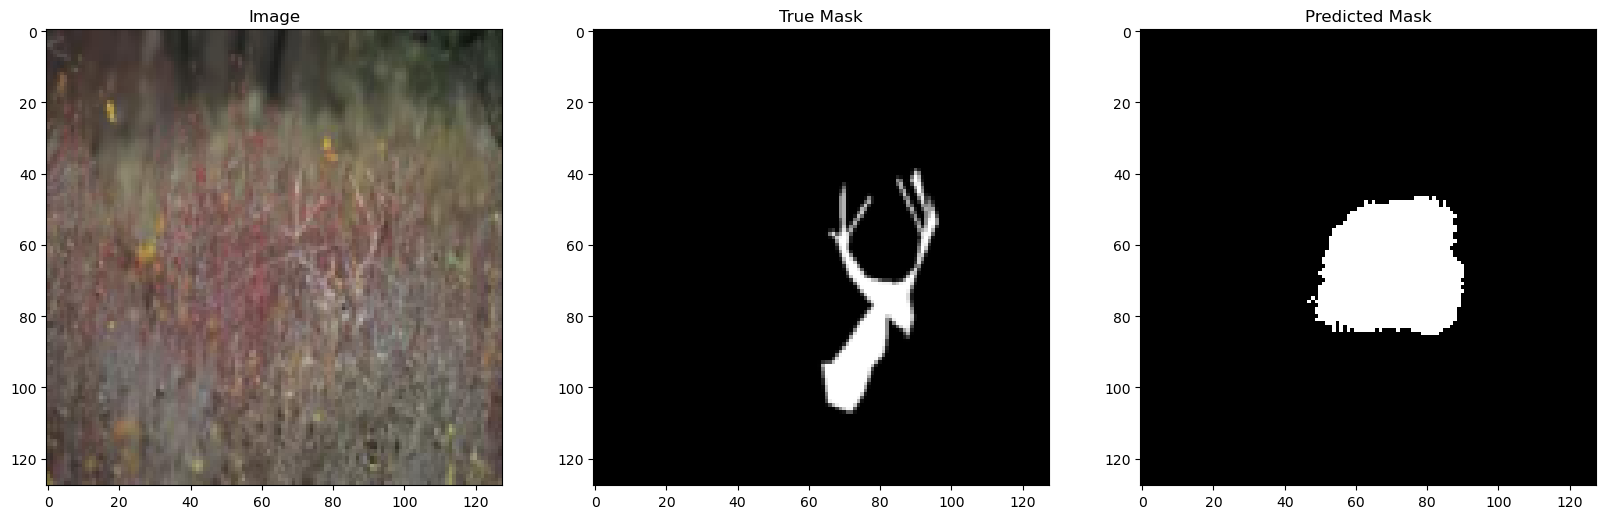

In [14]:
image, mask = next(iter(train_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.round(pred)
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [14]:
IoU_value = 0
for image, mask in train_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.round(pred)
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16)).item()
print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')

Intersection Over Union value = 0.3519369438290596


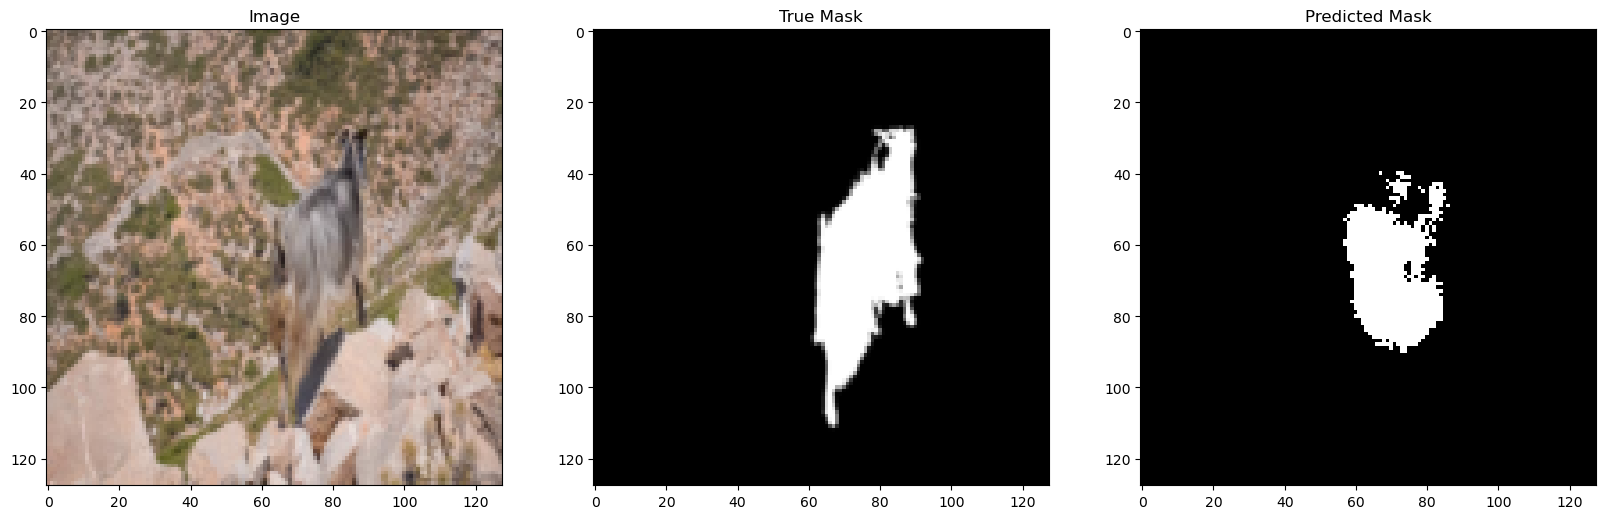

In [24]:
image, mask = next(iter(val_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.round(pred)
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

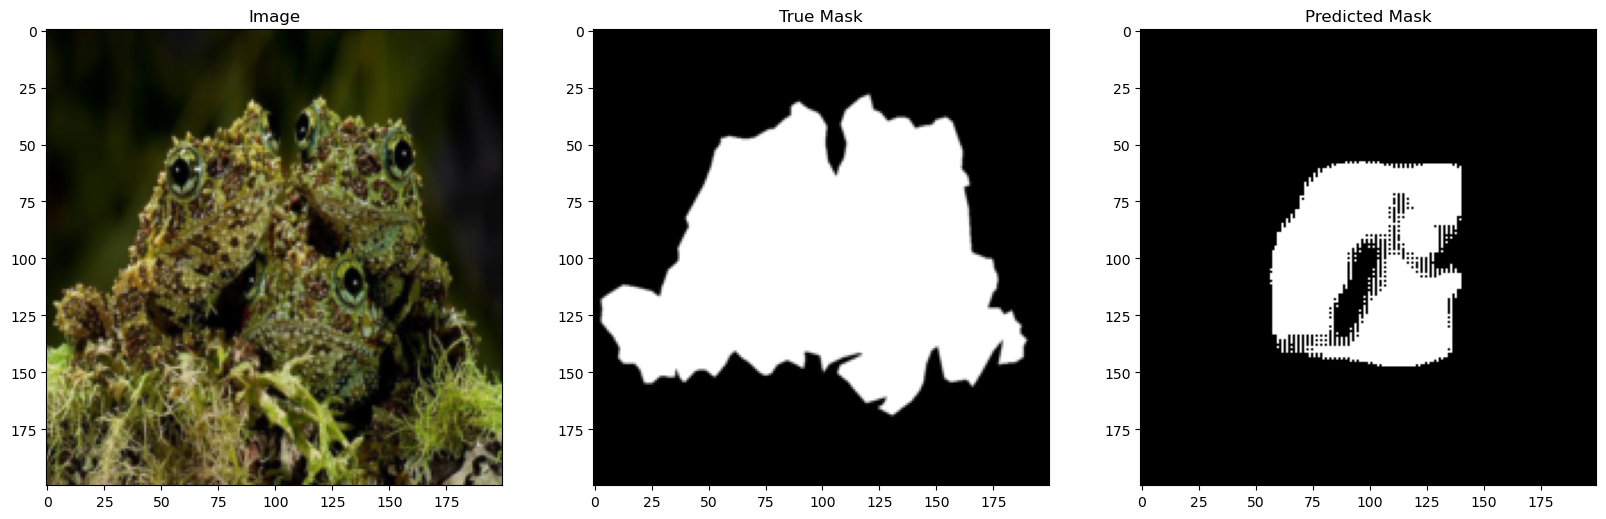

In [16]:
image, mask = next(iter(val_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.round(pred)
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [15]:
IoU_value = 0
for image, mask in val_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.round(pred)
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16)).item()
print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.22031427547335625
